In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from sklearn.decomposition import PCA

np.set_printoptions(linewidth=200)
matplotlib_color_order = plt.rcParams['axes.prop_cycle'].by_key()['color']
matplotlib_color_order[0] = 'blue'
color_order_alt = ['cyan', 'yellow', 'chartreuse']

# %matplotlib widget
%matplotlib inline

## Visualize Robot Movements

In [2]:
train_data_directory = "data/train/"
test_data_directory = "data/test/"

def get_file_path(movement: str, number: int, train: bool = True) -> str:
    if train:
        filepath = os.path.join(train_data_directory, f"{movement}_{number}.npy")
    else: 
        filepath = os.path.join(test_data_directory, f"{movement}_{number}t.npy")
    return filepath

In [3]:
def animate_movement(filepath: str) -> animation.FuncAnimation:
    """Animate the movement of the robot given the file path to the data"""

    data = np.load(filepath)
    data = data.reshape(38,3,100)
    animation.writer = animation.writers['ffmpeg']

    plt.ioff()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # write the update function, specifically including the ax.clear() function this was important.
    def update(i):
        ax.clear()
        ax.plot(data[:,:,i][:,0], data[:,:,i][:,1], data[:,:,i][:,2], 'o-', markersize=2)
        ax.set_title("Robot Movement Visualization")
        ax.set_xlim(-750, 1000)
        ax.set_ylim(-1000, 1000)
        ax.set_zlim(-750, 1000)
        return ax

    ani = animation.FuncAnimation(fig, update, frames=range(100), interval=25)

    return ani

In [4]:
# Animate the movement of the robot
# filepath = get_file_path("walking", 1)
# ani = animate_movement(filepath=filepath)
# HTML(ani.to_html5_video())

## Load Data

In [5]:
num_train_samples = 5
num_test_samples = 1
num_frames_per_sample = 100

def load_movement_data(train: bool = True) -> tuple[np.array, np.array]:
    """Load all the training or test data into a single numpy array"""
    num_samples = num_train_samples if train else num_test_samples

    data_loaded = []
    labels = []
    movements = ["jumping", "running", "walking"]
    for movement in movements:
        for i in range(1, num_samples + 1):
            filepath = get_file_path(movement, i, train=train)
            data_loaded.append(np.load(filepath))

            # Append the movement repeatedly for each frame in the sample.
            labels += [movement] * num_frames_per_sample

    all_samples = np.hstack(data_loaded)
    labels = np.array(labels)

    # transpose data so samples are the rows and features are the columns as expected by sklearn PCA
    return all_samples.T, labels

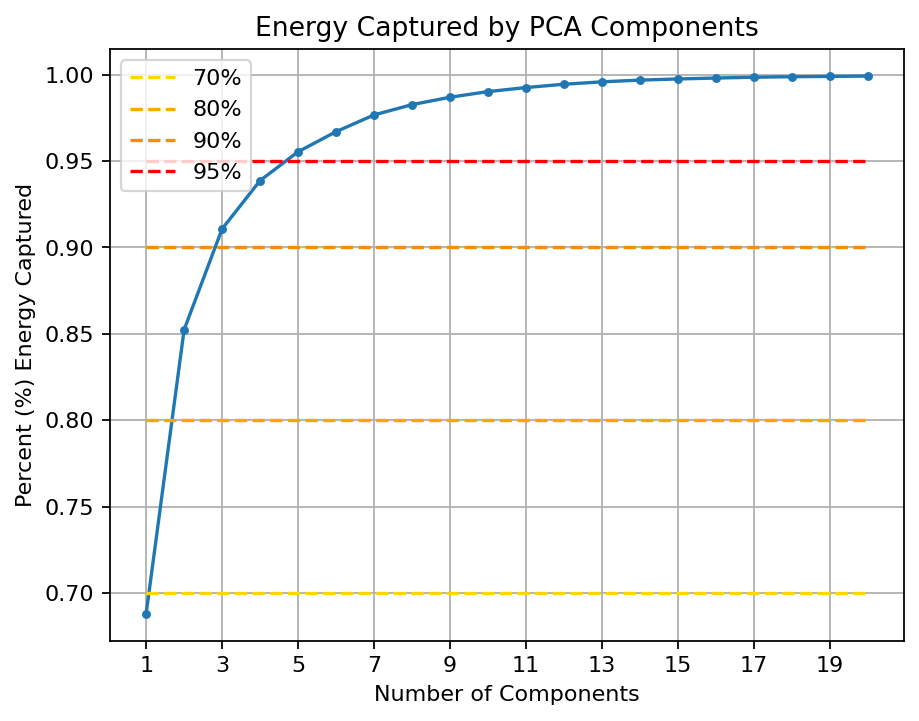

In [6]:
train_movement_data, train_labels = load_movement_data(train=True)

pca_model_for_task_1 = PCA()
pca_model_for_task_1.fit(train_movement_data)

energy_by_components = np.sqrt(np.cumsum(pca_model_for_task_1.singular_values_**2))/np.sqrt(np.sum(pca_model_for_task_1.singular_values_**2))

num_to_plot = 20

fig = plt.figure(dpi=160)
ax = fig.add_subplot(111)
ax.plot(np.arange(1,115)[:num_to_plot], energy_by_components[:num_to_plot], 'o-', markersize=3)
ax.grid()
ax.set_title("Energy Captured by PCA Components")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Percent (%) Energy Captured")
ax.hlines(0.70, 1, num_to_plot, linestyles='dashed', colors='gold', label='70%')
ax.hlines(0.80, 1, num_to_plot, linestyles='dashed', colors='orange', label='80%')
ax.hlines(0.90, 1, num_to_plot, linestyles='dashed', colors='darkorange', label='90%')
ax.hlines(0.95, 1, num_to_plot, linestyles='dashed', colors='r', label='95%')

# ax.set_ylim(0, 1)
ax.set_xticks(np.arange(1, num_to_plot, 2))
plt.legend()
plt.savefig("visualizations/energy_by_components.png")
plt.show()


## PCA on Robot Movement Samples

In [7]:
def pca_plotting_helper(
    data_transformed: np.array,
    k_components: int,
    labels: np.array
) -> None:
    """Plot the transformed data in 2D or 3D"""
    if k_components == 2:
        fig = plt.figure(dpi=160)
        ax = fig.add_subplot(111)

        for i, label in enumerate(np.unique(labels)):
            ax.scatter(
                data_transformed[labels == label, 0],
                data_transformed[labels == label, 1],
                label=label,
                alpha=0.25,
                color=matplotlib_color_order[i],
            )
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")

    elif k_components == 3:
        fig = plt.figure(dpi=160)
        ax = fig.add_subplot(111, projection='3d')

        for i, label in enumerate(np.unique(labels)):
            ax.scatter(
                data_transformed[labels == label, 0],
                data_transformed[labels == label, 1],
                data_transformed[labels == label, 2],
                label=label,
                alpha=0.25,
                color=matplotlib_color_order[i],
            )
        
        ax.view_init(elev=20, azim=-15)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
    
    else:
        raise ValueError(f"Only 2 or 3 components can be plotted, however {k_components} were given.")

    ax.set_title(f"PCA Projection of Robot Movement with {k_components} Components")
    plt.legend()
    plt.savefig(f"visualizations/pca_{k_components}_components_plot.png")
    plt.show()


def fit_k_component_pca(
    data: np.array,
    labels: np.array,
    k_components: int = 2,
    plot: bool = True
) -> PCA:
    """Fit a PCA model to the data and plot the transformed data"""
    my_pca_model = PCA(n_components=k_components)
    my_pca_model.fit(data)
    data_transformed = my_pca_model.transform(data)

    if plot:
        pca_plotting_helper(data_transformed, k_components, labels)  

    return my_pca_model

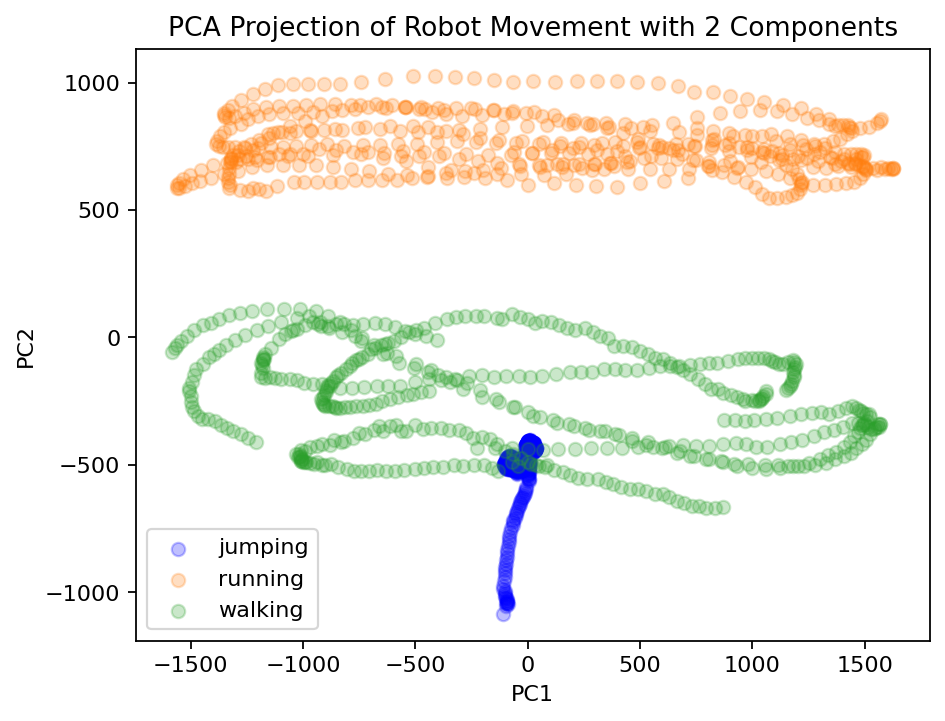

In [8]:
train_movement_data, train_labels = load_movement_data(train=True)
pca_model_2 = fit_k_component_pca(train_movement_data, train_labels, k_components=2)

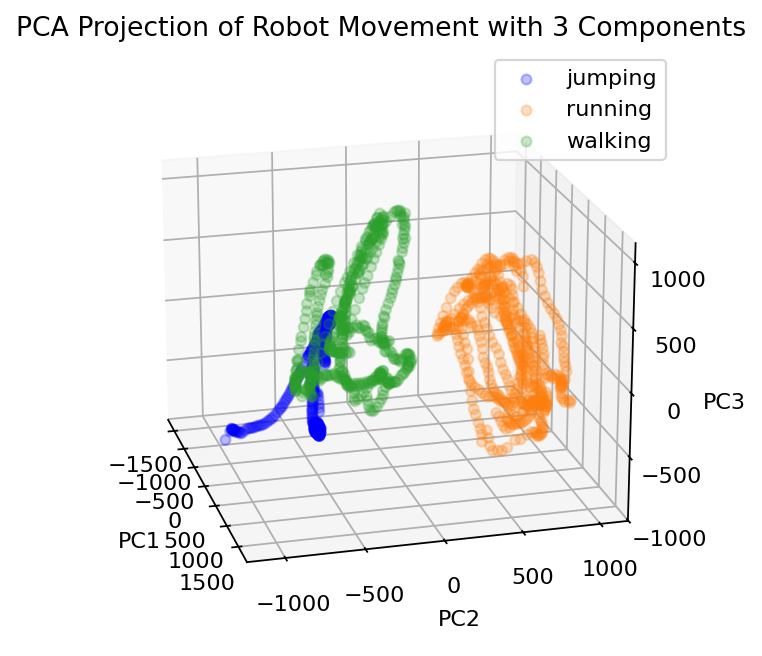

In [9]:
pca_model_3 = fit_k_component_pca(train_movement_data, train_labels, k_components=3)

In [10]:
# compute mean of each label after performing PCA
# reclassify each point based on min distance from mean of each label
# compute accuracy

ORDER_OF_NORM = 2

from sklearn.base import BaseEstimator, ClassifierMixin

class CustomDistanceClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self) -> None:
        pass

    def fit(self, X: np.array, y: np.array) -> "CustomDistanceClassifier":
        """Compute the means of each label."""
        self.labels = np.unique(y)
        self.means = np.array(
            [ X[y == label].mean(axis=0) for label in self.labels ]
        )
        return self
    
    def predict(self, X):
        """Compute distance of points in X from each mean."""
        distances = np.array(
            [ np.linalg.norm(X - mean, ord=ORDER_OF_NORM, axis=1) for mean in self.means ]
        )
        index_of_min_distance = np.argmin(distances, axis=0)
        return self.labels[index_of_min_distance]


In [11]:
train_movement_data_transformed = pca_model_2.transform(train_movement_data)

In [12]:
my_classifier_2 = CustomDistanceClassifier()
my_classifier_2.fit(train_movement_data_transformed, train_labels)

predicted_labels = my_classifier_2.predict(train_movement_data_transformed)

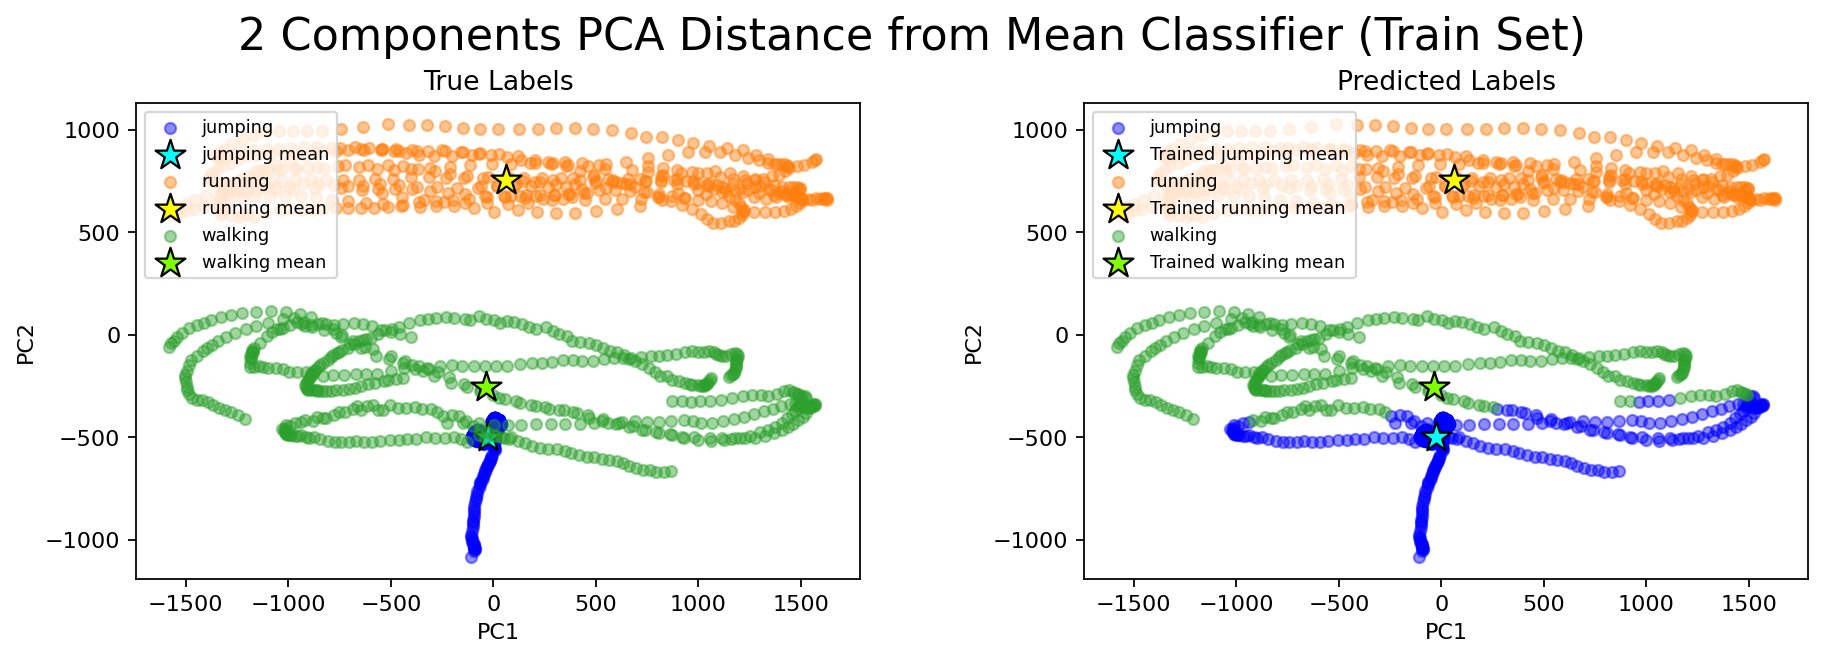

In [13]:
fig = plt.figure(figsize=(12, 4), dpi=160)
ax0 = fig.add_subplot(121)

for i, label in enumerate(np.unique(train_labels)):
    ax0.scatter(
        train_movement_data_transformed[train_labels == label, 0],
        train_movement_data_transformed[train_labels == label, 1],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
        alpha=.45,
    )
    ax0.scatter(my_classifier_2.means[i, 0], my_classifier_2.means[i, 1], s=200, label=f"{label} mean", color=color_order_alt[i], edgecolor='k', marker="*")

ax0.set_xlabel("PC1")
ax0.set_ylabel("PC2")
ax0.legend(loc='upper left', fontsize=8)
ax0.set_title("True Labels")
ax0.set_aspect(1)

ax1 = fig.add_subplot(122)

for i, label in enumerate(np.unique(predicted_labels)):
    ax1.scatter(
        train_movement_data_transformed[predicted_labels == label, 0],
        train_movement_data_transformed[predicted_labels == label, 1],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
        alpha=.45,
    )
    ax1.scatter(my_classifier_2.means[i, 0], my_classifier_2.means[i, 1], s=200, label=f"Trained {label} mean", color=color_order_alt[i], edgecolor='k', marker="*")

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title("Predicted Labels")
ax1.set_aspect(1)


plt.suptitle("2 Components PCA Distance from Mean Classifier (Train Set)", fontsize=20)
plt.tight_layout()
plt.savefig("visualizations/pca_distance_from_mean_classifier_2d.png")
plt.show()

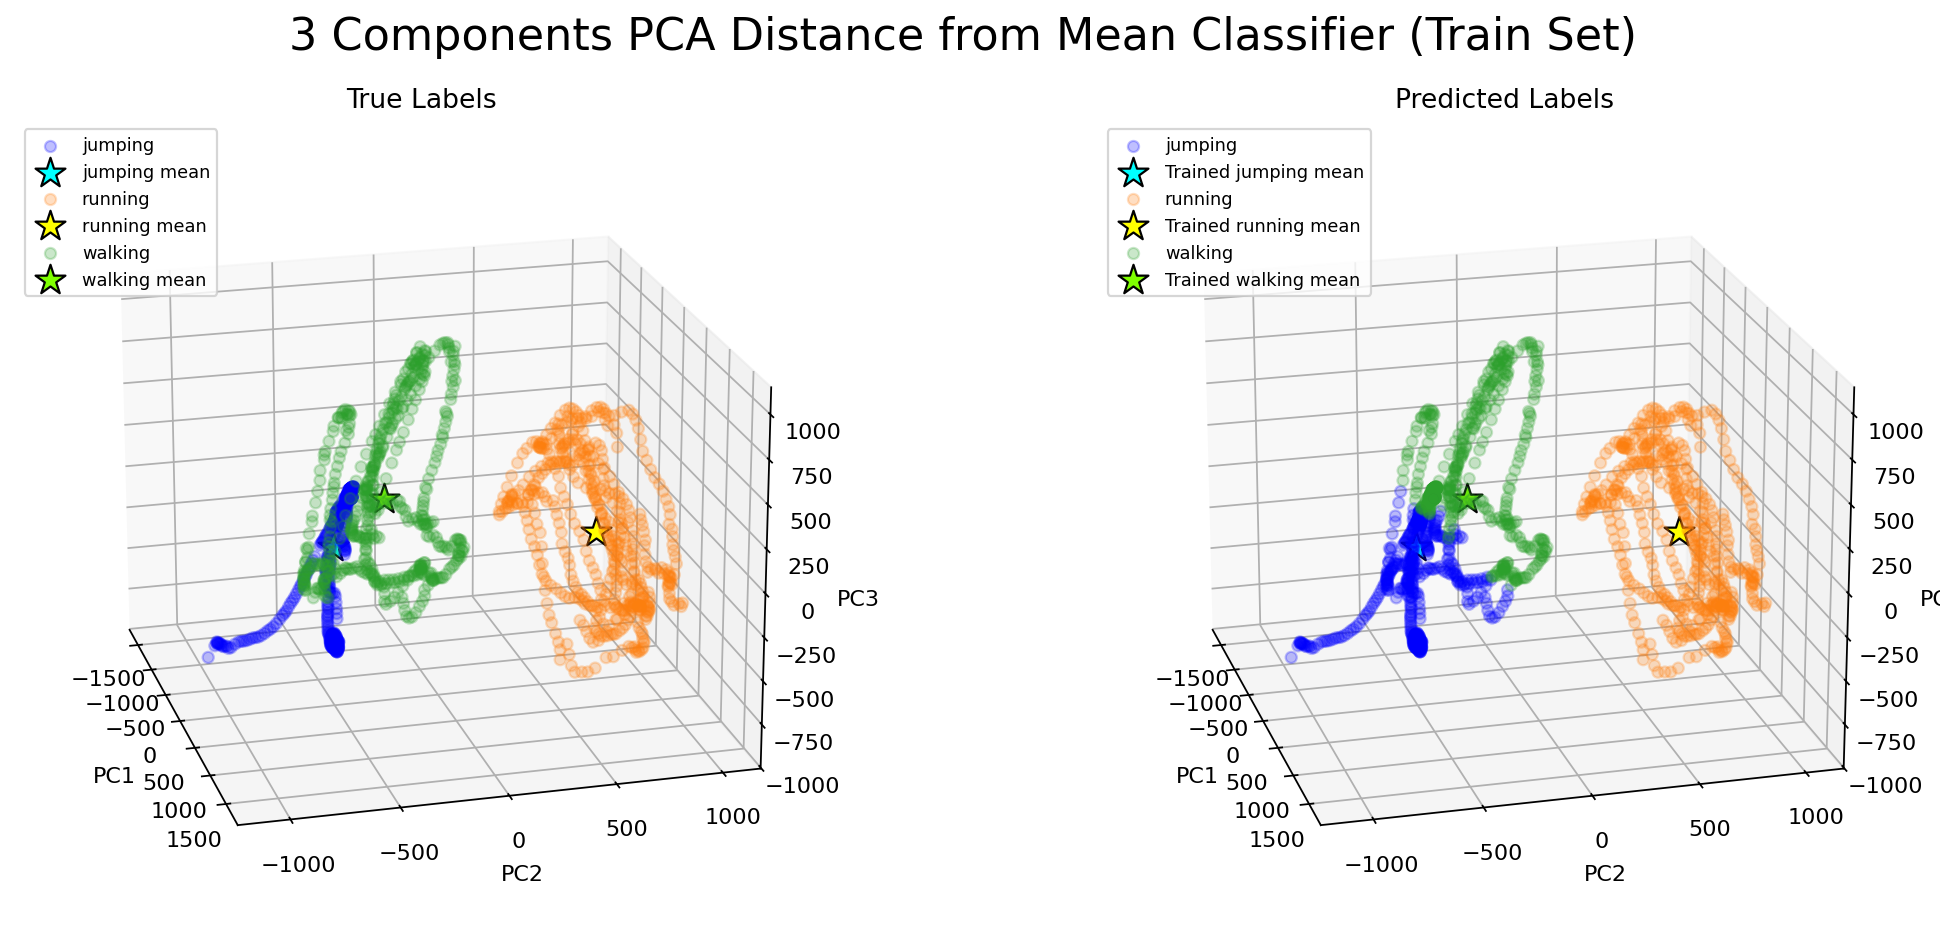

In [14]:
pca_model_3 = fit_k_component_pca(train_movement_data, train_labels, k_components=3, plot=False)

train_movement_data_transformed = pca_model_3.transform(train_movement_data)

my_classifier_3 = CustomDistanceClassifier()
my_classifier_3.fit(train_movement_data_transformed, train_labels)

predicted_labels = my_classifier_3.predict(train_movement_data_transformed)

fig = plt.figure(figsize=(14, 6), dpi=160)
ax0 = fig.add_subplot(121, projection='3d')

for i, label in enumerate(np.unique(train_labels)):
    ax0.scatter(
        train_movement_data_transformed[train_labels == label, 0],
        train_movement_data_transformed[train_labels == label, 1],
        train_movement_data_transformed[train_labels == label, 2],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
        alpha=.25,
    )
    ax0.scatter(my_classifier_3.means[i, 0], my_classifier_3.means[i, 1], my_classifier_3.means[i, 2], s=200, label=f"{label} mean", color=color_order_alt[i], edgecolor='k', marker="*")

ax0.view_init(elev=20, azim=-15)
ax0.set_xlabel("PC1")
ax0.set_ylabel("PC2")
ax0.set_zlabel("PC3")
ax0.legend(loc='upper left', fontsize=8)
ax0.set_title("True Labels")

ax1 = fig.add_subplot(122, projection='3d')

for i, label in enumerate(np.unique(predicted_labels)):
    ax1.scatter(
        train_movement_data_transformed[predicted_labels == label, 0],
        train_movement_data_transformed[predicted_labels == label, 1],
        train_movement_data_transformed[predicted_labels == label, 2],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
        alpha=.25,
    )
    ax1.scatter(my_classifier_3.means[i, 0], my_classifier_3.means[i, 1], my_classifier_3.means[i, 2], s=200, label=f"Trained {label} mean", color=color_order_alt[i], edgecolor='k', marker="*")

ax1.view_init(elev=20, azim=-15)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title("Predicted Labels")


plt.suptitle("3 Components PCA Distance from Mean Classifier (Train Set)", fontsize=20)
plt.tight_layout()

plt.savefig("visualizations/pca_distance_from_mean_classifier_3d.png")
plt.show()

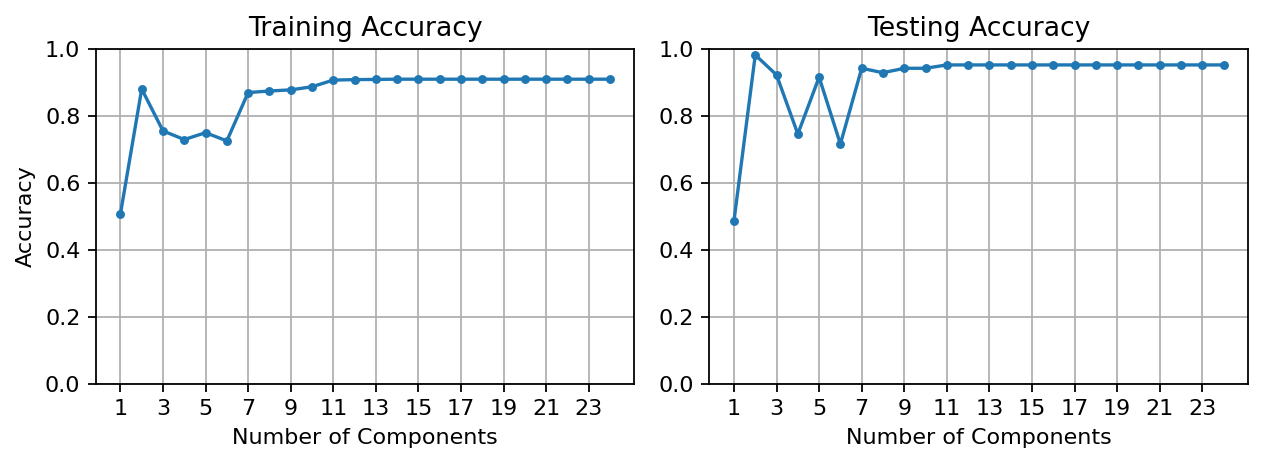

In [15]:
train_scores = []
predicted_labels = []

num_to_plot = 25

for k in range(1,num_to_plot):
    pca_model = PCA(n_components=k)
    train_movement_data_transformed = pca_model.fit_transform(train_movement_data)
        
    clasif_model = CustomDistanceClassifier()
    clasif_model.fit(train_movement_data_transformed, train_labels)
    train_scores.append(clasif_model.score(train_movement_data_transformed, train_labels))
    predicted_labels.append(clasif_model.predict(train_movement_data_transformed))

test_movement_data, test_labels = load_movement_data(train=False)

test_scores = []
test_predicted_labels = []

for k in range(1,num_to_plot):
    pca_model = PCA(n_components=k)
    train_movement_data_transformed = pca_model.fit_transform(train_movement_data)
        
    clasif_model = CustomDistanceClassifier()
    clasif_model.fit(train_movement_data_transformed, train_labels)

    # transform the test data with the trained PCA model
    test_movement_data_transformed = pca_model.transform(test_movement_data)
    
    test_scores.append(clasif_model.score(test_movement_data_transformed, test_labels))
    test_predicted_labels.append(clasif_model.predict(test_movement_data_transformed))


fig = plt.figure(figsize=(8, 3), dpi=160)

ax0 = fig.add_subplot(121)
ax0.plot(np.arange(1,num_to_plot), np.array(train_scores), 'o-', markersize=3)
ax0.set_xticks(np.arange(1,num_to_plot, num_to_plot//10))
ax0.set_title("Training Accuracy")
ax0.set_xlabel("Number of Components")
ax0.set_ylabel("Accuracy")
ax0.set_ylim(0, 1)
ax0.grid()

ax1 = fig.add_subplot(122, sharey=ax0)
ax1.plot(np.arange(1,num_to_plot), np.array(test_scores), 'o-', markersize=3)
ax1.set_xticks(np.arange(1,num_to_plot, num_to_plot//10))
ax1.set_title("Testing Accuracy")
ax1.set_xlabel("Number of Components")
ax1.grid()

plt.tight_layout()

plt.savefig("visualizations/train_and_test_accuracy_by_num_components.png")
plt.show()

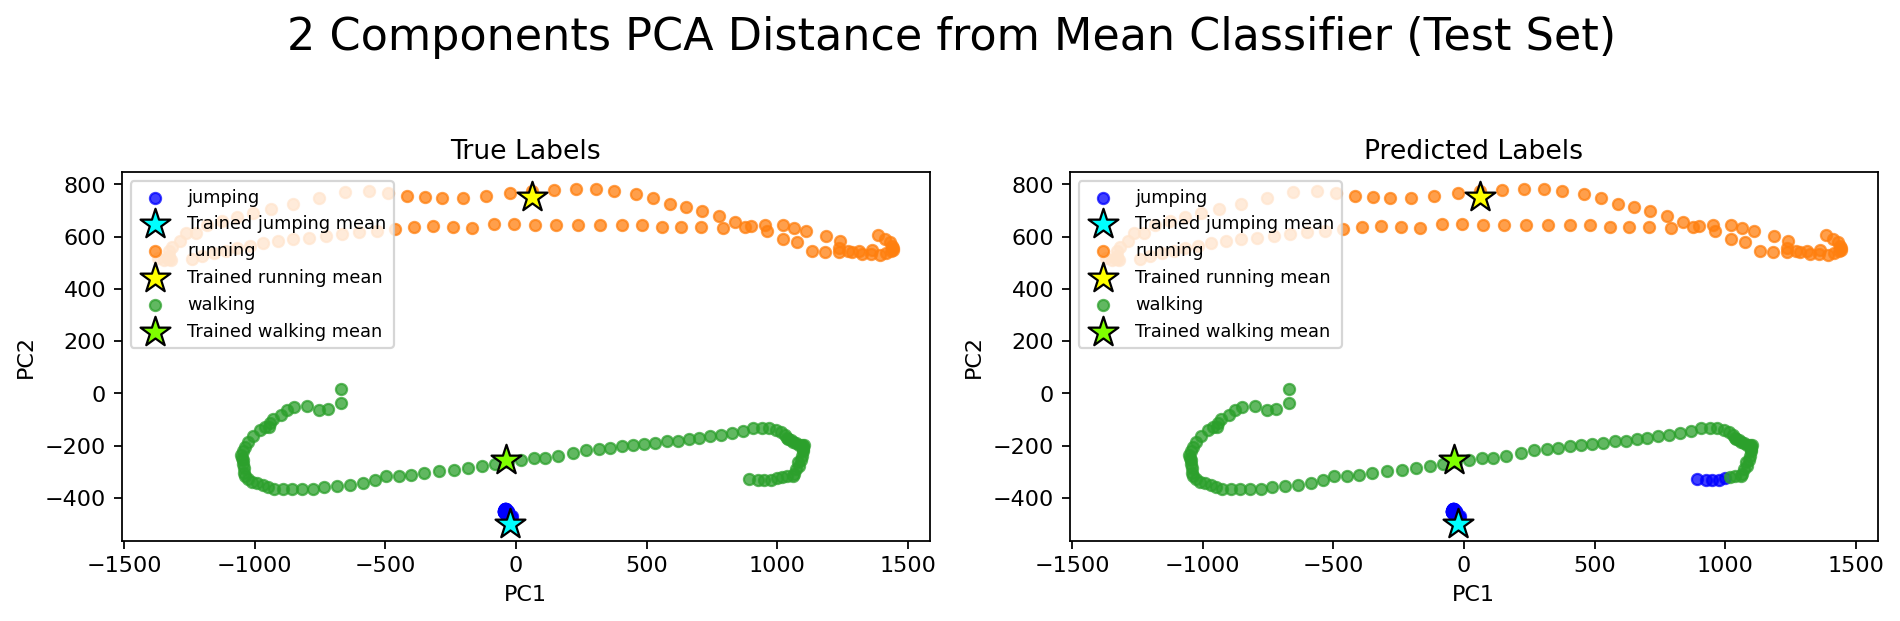

In [16]:
test_movement_data_transformed = pca_model_2.transform(test_movement_data)
predicted_labels_2 = my_classifier_2.predict(test_movement_data_transformed)

fig = plt.figure(figsize=(12, 4), dpi=160)
ax0 = fig.add_subplot(121)

for i, label in enumerate(np.unique(test_labels)):
    ax0.scatter(
        test_movement_data_transformed[test_labels == label, 0],
        test_movement_data_transformed[test_labels == label, 1],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
        alpha=.75,
    )
    ax0.scatter(my_classifier_2.means[i, 0], my_classifier_2.means[i, 1], s=200, label=f"Trained {label} mean", color=color_order_alt[i], edgecolor='k', marker="*")

ax0.set_xlabel("PC1")
ax0.set_ylabel("PC2")
ax0.legend(loc='upper left', fontsize=8)
ax0.set_title("True Labels")
ax0.set_aspect(1)

ax1 = fig.add_subplot(122)

for i, label in enumerate(np.unique(predicted_labels_2)):
    ax1.scatter(
        test_movement_data_transformed[predicted_labels_2 == label, 0],
        test_movement_data_transformed[predicted_labels_2 == label, 1],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
        alpha=.75,
    )
    ax1.scatter(my_classifier_2.means[i, 0], my_classifier_2.means[i, 1], s=200, label=f"Trained {label} mean", color=color_order_alt[i], edgecolor='k', marker="*")

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title("Predicted Labels")
ax1.set_aspect(1)


plt.suptitle("2 Components PCA Distance from Mean Classifier (Test Set)", fontsize=20)
plt.tight_layout()
plt.savefig("visualizations/pca_distance_from_mean_classifier_2d_test_set.png")
plt.show()

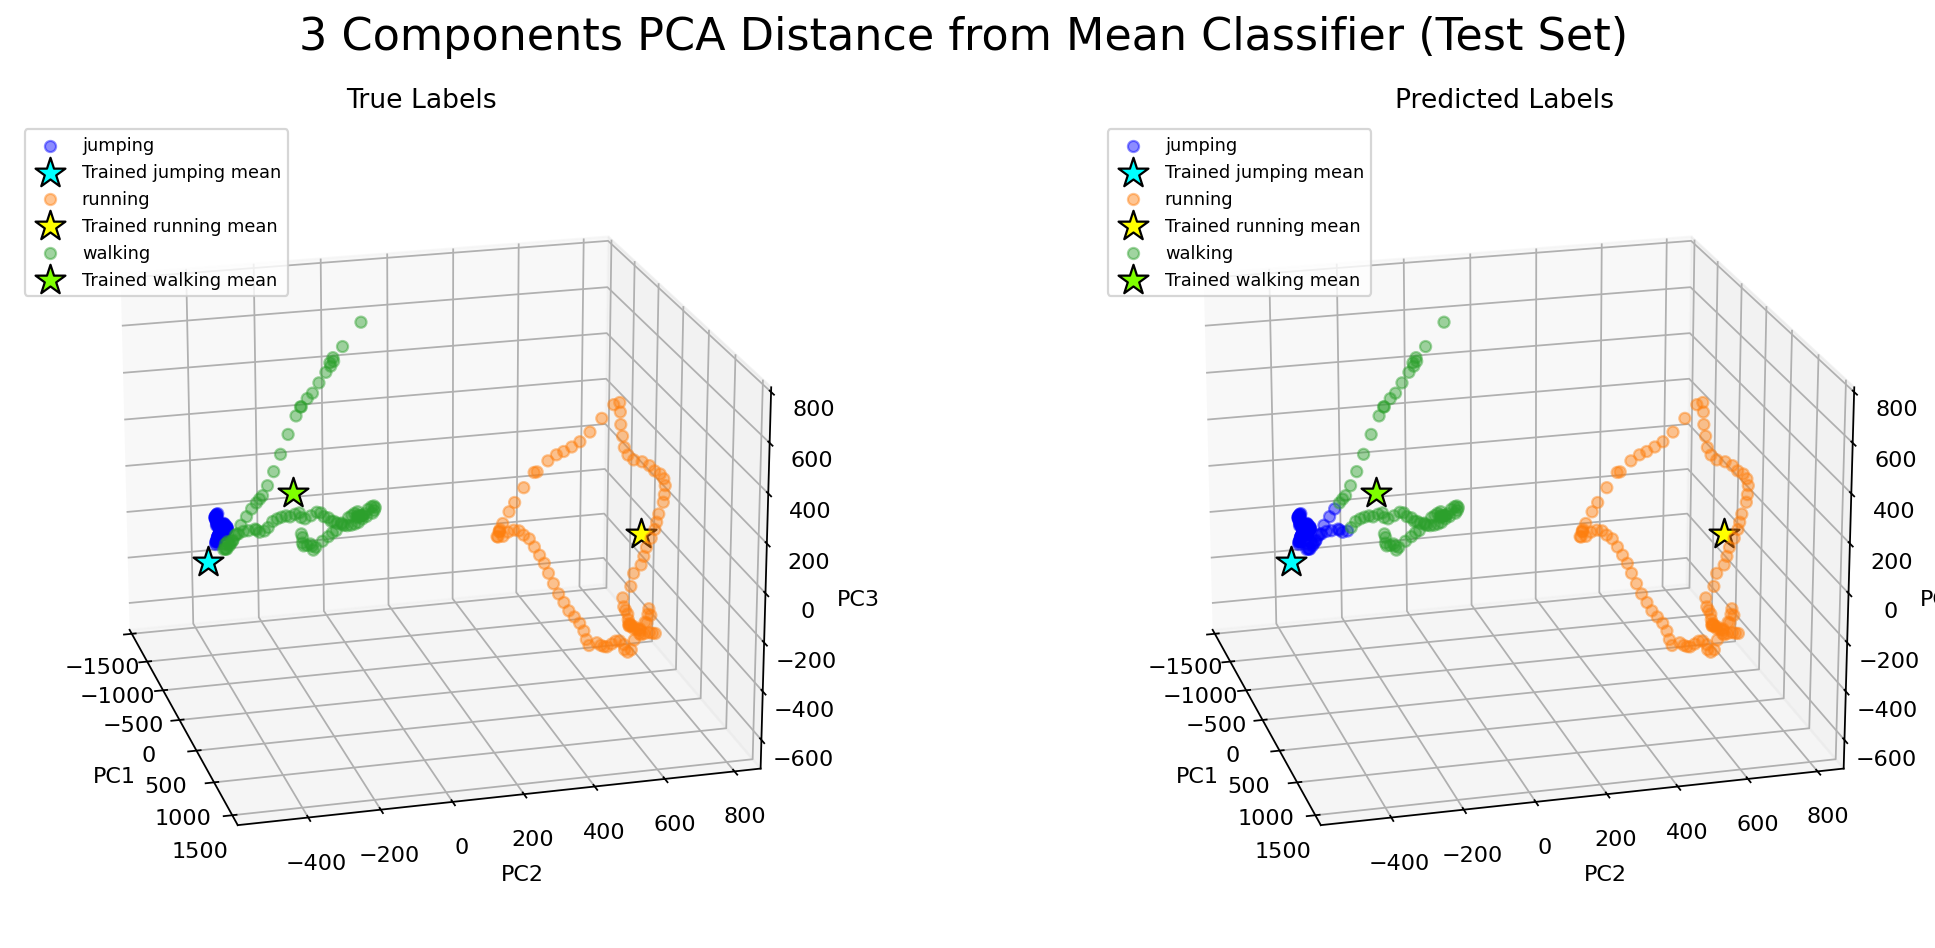

In [17]:
test_movement_data_transformed = pca_model_3.transform(test_movement_data)
predicted_labels_3 = my_classifier_3.predict(test_movement_data_transformed)

fig = plt.figure(figsize=(14, 6), dpi=160)
ax0 = fig.add_subplot(121, projection='3d')

for i, label in enumerate(np.unique(test_labels)):
    ax0.scatter(
        test_movement_data_transformed[test_labels == label, 0],
        test_movement_data_transformed[test_labels == label, 1],
        test_movement_data_transformed[test_labels == label, 2],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
        alpha=.45,
    )
    ax0.scatter(my_classifier_3.means[i, 0], my_classifier_3.means[i, 1], my_classifier_3.means[i, 2], s=200, label=f"Trained {label} mean", color=color_order_alt[i], edgecolor='k', marker="*")

ax0.view_init(elev=20, azim=-15)
ax0.set_xlabel("PC1")
ax0.set_ylabel("PC2")
ax0.set_zlabel("PC3")
ax0.legend(loc='upper left', fontsize=8)
ax0.set_title("True Labels")

ax1 = fig.add_subplot(122, projection='3d')

for i, label in enumerate(np.unique(predicted_labels)):
    ax1.scatter(
        test_movement_data_transformed[predicted_labels_3 == label, 0],
        test_movement_data_transformed[predicted_labels_3 == label, 1],
        test_movement_data_transformed[predicted_labels_3 == label, 2],
        label=label,
        color=matplotlib_color_order[i],
        s=25,
        alpha=.45,
    )
    ax1.scatter(my_classifier_3.means[i, 0], my_classifier_3.means[i, 1], my_classifier_3.means[i, 2], s=200, label=f"Trained {label} mean", color=color_order_alt[i], edgecolor='k', marker="*")

ax1.view_init(elev=20, azim=-15)
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax1.legend(loc='upper left', fontsize=8)
ax1.set_title("Predicted Labels")


plt.suptitle("3 Components PCA Distance from Mean Classifier (Test Set)", fontsize=20)
plt.tight_layout()

plt.savefig("visualizations/pca_distance_from_mean_classifier_3d_test_set.png")
plt.show()

In [18]:
for k, predicted_label in enumerate(predicted_labels):
    for i in range(len(train_labels)):
        if predicted_label[i] == train_labels[i]:
            continue
        # else:
            # print(f"With {k+1:02} components, sample point {i+1:02} was predicted as {predicted_label[i]} but was actually {labels[i]}")
# print(f"k_modes: {k}", clasif_model.predict(movement_data_train_transformed))

In [19]:
# TODO: Next I want to plot the original training data and their means with the predicted labels of the test set